In [1]:
""" 
NOTEBOOK :  ntbk_diag_ams-aies_gcb.ipynb 

This notebook produces Figure 6 of the paper: 

Sospedra-Alfonso, R., Gooya, P., Exenberger, J.,: Adjustment of decadal ocean carbon sink predictions 
using deep learning, Artif. I. Earth Syst., XX(XX), XXXX-XXXX, 2025. https://doi.org/XXXX

STATUS  : Complete
COMMENTS: None
"""

' \nNOTEBOOK :  ntbk_diag_ams-aies_gcb.ipynb \n\nThis notebook produces Figure 6 of the paper: \n\nSospedra-Alfonso, R., Gooya, P., Exenberger, J.,: Adjustment of decadal ocean carbon sink predictions \nusing deep learning, Artif. I. Earth Syst., XX(XX), XXXX-XXXX, 2025. https://doi.org/XXXX\n\nSTATUS  : Complete\nCOMMENTS: (1)  Monthly to annual conversion done before alignment of annual mean data\n               -- we checked that these two steps commute, noting that the alignment would be \n                  on monthly data instead of annual, with time_scale = 12 instead of time_scale=1\n'

In [2]:
import os
import yaml 

filename = f'{os.getcwd()[:-10]}/config.yaml'
with open(filename) as f:
    dict_yaml = yaml.load(f, Loader=yaml.loader.SafeLoader)
    
dir_source   = dict_yaml['dir_source']
nlead_years  = 1 

var          = dict_yaml['variable'][0]
model_trn    = dict_yaml['models_to_train'][0]
model_tst    = dict_yaml['models_to_test'][0]
verification = dict_yaml['verification'][0]

list_data    = [key for key in dict_yaml['list_data_options'] if key[4:] != 'tadj']

domain       = dict_yaml['choose_domain'][0]
resolution   = dict_yaml['choose_common_resolution'][0]

dir_frnt_obs = dict_yaml['dir_frnt_obs']
dir_frnt_mdl = dict_yaml['dir_frnt_mdl']
dir_frnt_gcb = dict_yaml['dir_frnt_l2m']

dir_frnt_adj = dict_yaml['dir_frnt_adj']

dir_frnt_out = dict_yaml['dir_frnt_diag']

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, f'{dir_source}')

from modules_nn.data_load             import (load_verification,
                                              load_forecasts)
from modules_nn.data_preprocessing    import preprocess_data


from modules_aies.info_mdl            import mdl_module    # DONE
from modules_aies.info_obs            import obs_module    # DONE
from modules_aies.info_var            import var_module    # DONE
from modules_aies.info_plt            import plt_module    # DONE

from modules_aies.data_load           import load_nadj_ensemble       
from modules_aies.data_preprocessing  import (align_data_to_common_base,
                                              merge_datasets)
from modules_aies.data_postprocessing import (write_monthly_to_annual,
                                              sequential_bias_adjustment) 

from modules_aies.util_glbavg         import *                          
from modules_aies.util_unitchg        import UnitChange                 

from modules_aies.plot_maps           import new_cmap_with_white
from modules_aies.diagnostics_gcb     import diagnostics_maps_gcb

In [4]:
units_KgCm2yr1 = r'kgC m-2 yr-1'

## Set Up ##

In [5]:
dir_mdl_nadj = f'{dir_frnt_adj}/{verification}/{model_trn}/Autoencoder'
dir_mdl_xadj = f'{dir_frnt_adj}/{verification}/{model_trn}' 

In [6]:
dir_out      = f'{dir_frnt_out}/ntbk/{resolution}/{domain}/{var}' 
file_out_map = f'map_{var}_{verification}'

In [7]:
realm = var_module().var_dict[var]['realm']
grid  = var_module().var_dict[var]['grid']
units = var_module().var_dict[var]['units']

In [8]:
dict_inf_data = {}
dict_inf_data[model_trn] = mdl_module(dir_frnt_mdl).mdl_dict[model_trn] 
dict_inf_data[model_tst] = mdl_module(dir_frnt_gcb).mdl_dict[model_tst] 
dict_inf_data[verification] = obs_module(f'{dir_frnt_obs}').obs_dict[verification][var] 

In [9]:
dict_plt_data = plt_module([verification]+[model_trn]).plot_data_dict 

In [10]:
y0_trn = dict_inf_data[verification]['y0']
y1_trn = dict_inf_data[verification]['y1']
y0_trn = max([y0_trn,dict_inf_data[model_trn]['y0']])
y1_trn = min([y1_trn,dict_inf_data[model_trn]['y1']])
y0_trg = 1986 # first target year
y1_trg = 2021 # last  target year

In [11]:
verbose = True
if verbose:
    print("======")
    print(f"y0 {model_trn}: {dict_inf_data[model_trn]['y0']}")
    print(f"y1 {model_trn}: {dict_inf_data[model_trn]['y1']}")
    print("======")
    print(f"y0 {model_tst}: {dict_inf_data[model_tst]['y0']}")
    print(f"y1 {model_tst}: {dict_inf_data[model_tst]['y1']}")
    print("======")
    print(f"y0_trn: {y0_trn}")
    print(f"y1_trn: {y1_trn}")
    print("======")
    print(f"y0_trg: {y0_trg}")
    print(f"y1_trg: {y1_trg}")
    print("======")

y0 CanESM5.0-ems: 1981
y1 CanESM5.0-ems: 2023
y0 CanESM5.0-gcb-v2023.1: 2016
y1 CanESM5.0-gcb-v2023.1: 2023
y0_trn: 1982
y1_trn: 2021
y0_trg: 1986
y1_trg: 2021


## Load Data ##

In [12]:
obs_read = load_verification(dict_inf_data[verification]['dir'],
                             two_dim=True)

====
loading verification..
done


In [13]:
hnd_read = load_forecasts(dict_inf_data[model_trn]['dir'])
hnd_read = UnitChange(hnd_read).Int2Met(var)

====
loading forecasts..
done


In [14]:
hnd_read_gcb = load_forecasts(dict_inf_data[model_tst]['dir'])
hnd_read_gcb = UnitChange(hnd_read_gcb).Int2Met(var)

====
loading forecasts..
done


In [15]:
hnd_read_nadj = load_nadj_ensemble(f'{dir_mdl_nadj}', 
                                   file_key='*nn_adjusted*',
                                   EE=1,
                                   emean=True,
                                   model_test=model_tst).rename({'time':'lead_time'})

loading ensemble..
done


In [16]:
idisplay = False
if idisplay:
    display(obs_read)
    display(hnd_read)
    display(hnd_read_gcb)
    display(hnd_read_nadj)

## Merge Historical + GCB Forecasts ##

In [17]:
hnd_merged = merge_datasets(hnd_read.to_dataset(name=var),
                            hnd_read_gcb.to_dataset(name=var),
                            time0=1,
                            time1=12,
                            ds1_time='lead_time',
                            ds2_time='lead_time')[var]
hnd_merged = hnd_merged.rename({'time' : 'lead_time'})

In [18]:
hnd_nadj_merged = merge_datasets(hnd_read.to_dataset(name=var),
                            hnd_read_nadj,#.to_dataset(name=var),
                            time0=1,
                            time1=12,
                            ds1_time='lead_time',
                            ds2_time='lead_time')[var]
hnd_nadj_merged = hnd_nadj_merged.rename({'time' : 'lead_time'})

## Preprocess Data ##

In [19]:
obs_in, hnd_in = preprocess_data(obs_read,
                                 hnd_merged,
                                 nlead_years=nlead_years)
obs_in = obs_in.rename({'lead_time' : 'time'}).squeeze().to_dataset()
hnd_in = hnd_in.rename({'lead_time' : 'time'}).squeeze().to_dataset()

====
preprocessing data..
done


In [20]:
obs_in['time'] = np.arange(nlead_years*12)
hnd_in['time'] = np.arange(nlead_years*12)

In [21]:
idisplay = False
if idisplay:
    display(obs_in)
    display(hnd_in)

In [22]:
mask_ocean = spatial_mask(obs_in.isel(time=0).isel(year=0),
                          dataset=True) # spatial mask 

## Trim NN Adj GCB Forecasts ##

In [23]:
hnd_nadj = hnd_nadj_merged.sel(year=slice(hnd_in.year.values[0],
                                          hnd_in.year.values[-1])).rename({'lead_time' : 'time'})
hnd_nadj = hnd_nadj.sel(time=slice(hnd_in.time.values[0],
                                   hnd_in.year.values[-1])).to_dataset()

## Do Sequential Bias Adj to GCB Forecasts ##

In [24]:
hnd_badj,_ = sequential_bias_adjustment(obs_in,                              # ref dataset
                                        hnd_in,                              # raw dataset
                                        y0_train=y0_trn,                     # first year of training ()
                                        y0_test=hnd_read_gcb.year.values[0], # first year of gcb forecasts
                                        exclude_idx=-1)

bias correction: train period: 1982-2015, test year: 2016
bias correction: train period: 1982-2016, test year: 2017
bias correction: train period: 1982-2017, test year: 2018
bias correction: train period: 1982-2018, test year: 2019
bias correction: train period: 1982-2019, test year: 2020
bias correction: train period: 1982-2020, test year: 2021


## Set Data Dictionary ##

In [25]:
dict_data = {}
for key in list_data:
    dict_data[key] = {}
    for freq in ['mon', 'ann']:
        dict_data[key][freq] = {}
        for source in [model_trn]+[verification]:
            dict_data[key][freq][source] = {}  

In [26]:
dict_data['hnd']['mon'][model_trn]      = UnitChange(hnd_in).toKgCm2yr1()
dict_data['hnd_badj']['mon'][model_trn] = UnitChange(hnd_badj).toKgCm2yr1()
dict_data['hnd_nadj']['mon'][model_trn] = UnitChange(hnd_nadj).toKgCm2yr1()
dict_data['obs']['mon'][verification]   = UnitChange(obs_in).toKgCm2yr1()

In [27]:
idisplay = False
if idisplay:
    display(dict_data)

## Clean Time Dimension ##

In [28]:
for key in list_data:
    for source in [model_trn]+[verification]:
        if bool(dict_data[key]['mon'][source]):
            dict_data[key]['mon'][source]['time'] = np.arange(nlead_years*12)

## Convert Monthly to Annual ##

In [29]:
for key in [key for key in list_data if key != 'obs']: 
    if bool(dict_data[key]['mon'][model_trn]):
        dict_data[key]['ann'][model_trn] = write_monthly_to_annual(dict_data[key]['mon'][model_trn])
dict_data['obs']['ann'][verification]  = write_monthly_to_annual(dict_data['obs']['mon'][verification])    

## Align Data to Common Period ##

In [30]:
for key in [key for key in list_data if key[:3] != 'fct']:
    for source in [model_trn]+[verification]:
        if bool(dict_data[key]['ann'][source]):
            dict_data[key]['ann'][source]  = align_data_to_common_base(dict_data[key]['ann'][source].sel(year=slice(y0_trg,y1_trg)),
                                                                       nldyr=nlead_years,
                                                                       time_scale=1)

## Downstream Data Dictionary ## 

In [31]:
dict_error = {}
for key in [key for key in list_data if key != 'obs']:
    dict_error[key] = {}
    for freq in ['mon', 'ann']:
        dict_error[key][freq] = {}
        dict_error[key][freq][model_trn] = abs(dict_data[key][freq][model_trn] - dict_data['obs'][freq][verification])

## Figures ##

- Figure 6 (panels)

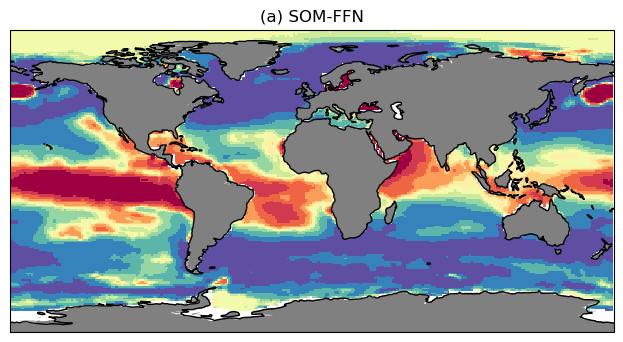

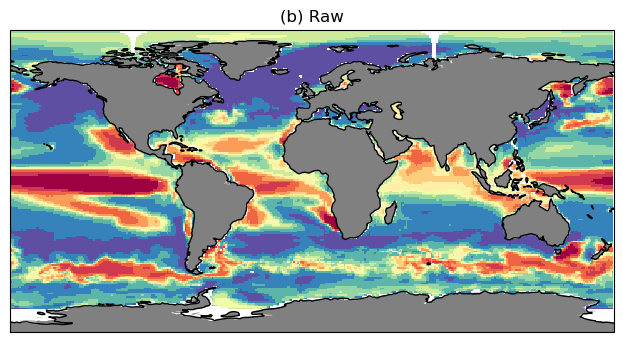

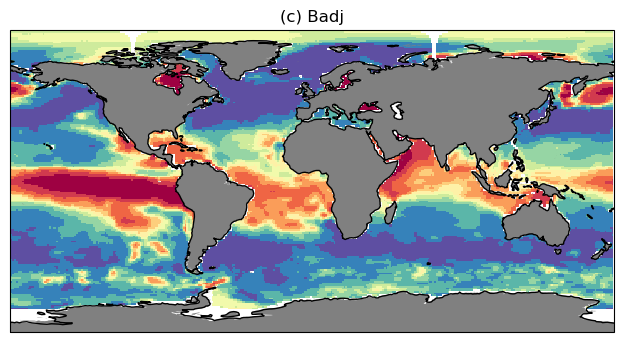

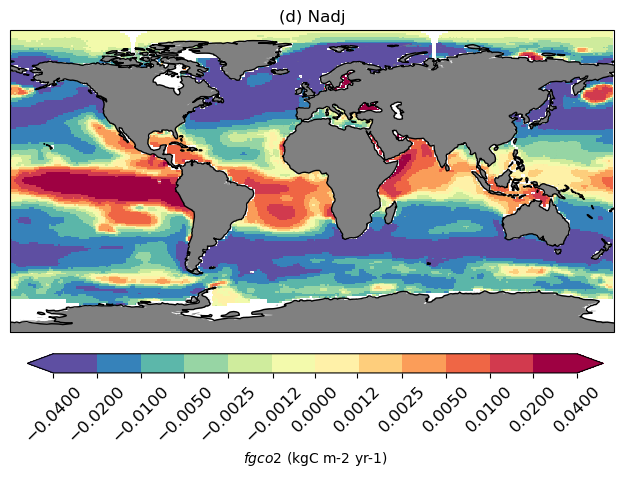

In [32]:
diagnostics_maps_gcb(list_data,
                     dict_data,
                     mask=mask_ocean,
                     year_to_show=None, # None shows default - last year available
                     cmap=dict_plt_data['fig6']['cmap'],
                     vals=dict_plt_data['fig6']['vals'],
                     titles=dict_plt_data['fig6']['title']['field'],
                     cbar_label=f'$fgco2$ ({units_KgCm2yr1})',
                     cbar_extend='both',
                     imshow=True,
                     dir_name=dir_out,
                     file_name=f'{file_out_map}',
                     show=True,
                     save=True)

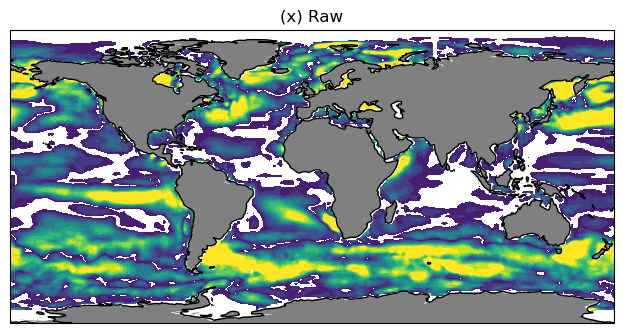

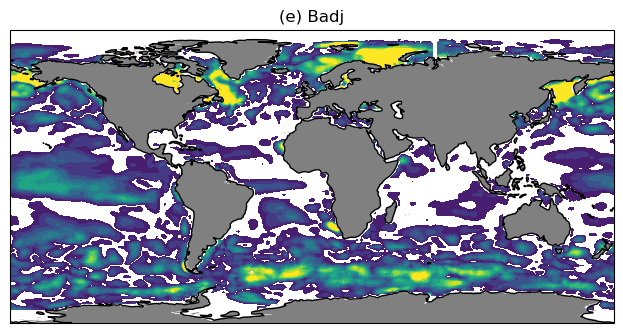

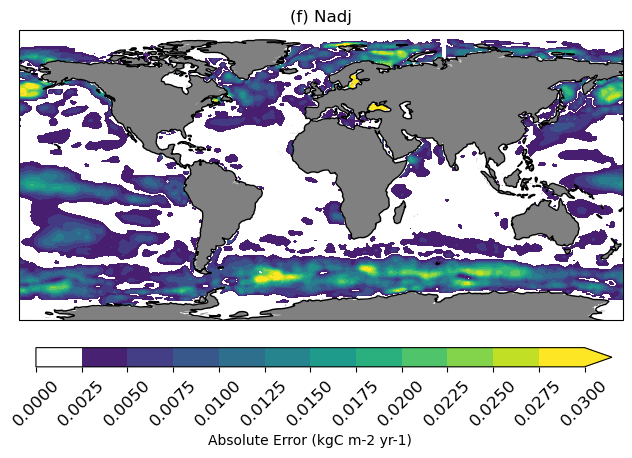

In [55]:
diagnostics_maps_gcb([key for key in list_data if key != 'obs'],
                     dict_error,
                     mask=mask_ocean,
                     year_to_show=None, # None shows default - last year available
                     cmap=new_cmap_with_white('viridis'), #'gist_earth_r', # 'pink_r', # 'hot_r', # 'gist_heat_r',#
                     cbar_label=f'Absolute Error ({units_KgCm2yr1})',
                     cbar_extend='max',
                     vmin=dict_plt_data['fig6']['ymin'],
                     vmax=dict_plt_data['fig6']['ymax'],
                     titles=dict_plt_data['fig6']['title']['error'],
                     dir_name=dir_out,
                     file_name=f'{file_out_map}_error',
                     show=True,
                     save=True)